# Импорт данных и зависимостей

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow.keras as keras

%config InlineBackend.figure_format = 'retina'

# загружаем данные
data = pd.read_csv('train.csv')
meal_info = pd.read_csv('meal_info.csv')
ff_info = pd.read_csv('fulfilment_center_info.csv')

# Анализ и подготовка данных

In [ ]:
data.shape, meal_info.shape, ff_info.shape

((456548, 9), (51, 3), (77, 5))

In [ ]:
data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [ ]:
data.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000


In [ ]:
meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [ ]:
ff_info.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [ ]:
# Объединим все датасеты
ds = pd.merge(data, meal_info, on='meal_id', how='left')
ds = pd.merge(ds, ff_info, on='center_id', how='left')
ds.sort_values(by='week', inplace=True)
print(ds.shape)

(456548, 15)


In [ ]:
ds.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1943,1362208,1,72,2704,251.29,282.33,0,1,80,Other Snacks,Thai,638,56,TYPE_C,3.9
1944,1060796,1,72,2492,387.03,389.03,0,1,82,Desert,Indian,638,56,TYPE_C,3.9
1945,1390499,1,72,2304,484.03,486.03,0,0,13,Desert,Indian,638,56,TYPE_C,3.9
1946,1472526,1,67,1885,135.86,134.86,0,0,1958,Beverages,Thai,638,56,TYPE_B,7.0


In [ ]:
ds.dtypes

id                         int64
week                       int64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders                 int64
category                  object
cuisine                   object
city_code                  int64
region_code                int64
center_type               object
op_area                  float64
dtype: object

In [ ]:
ds.isna().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64

In [ ]:
ds.loc[:,'discount'] = (np.abs(ds['checkout_price'] - ds['base_price'])/ds['base_price']).copy() # процент скидки
ds.loc[:,'is_promotion'] = (ds['checkout_price'] < ds['base_price']).astype(int).copy() # наличие промоакции
ds.loc[:,'num_orders'] = np.log1p(ds['num_orders']) # приведем целевую к более "нормальному" виду

ds.drop(['center_id', 'meal_id', 'base_price'], axis=1, inplace=True)
ds.drop('id', axis=1, inplace=True) # удалим, т.к. просто нумерация

In [ ]:
num_cols = ds.drop(['num_orders',
                    'emailer_for_promotion', # булевы переменные
                    'homepage_featured',
                   'is_promotion'], axis=1).select_dtypes(exclude='O').columns
cat_cols = ds.drop('num_orders', axis=1).select_dtypes(include='O').columns

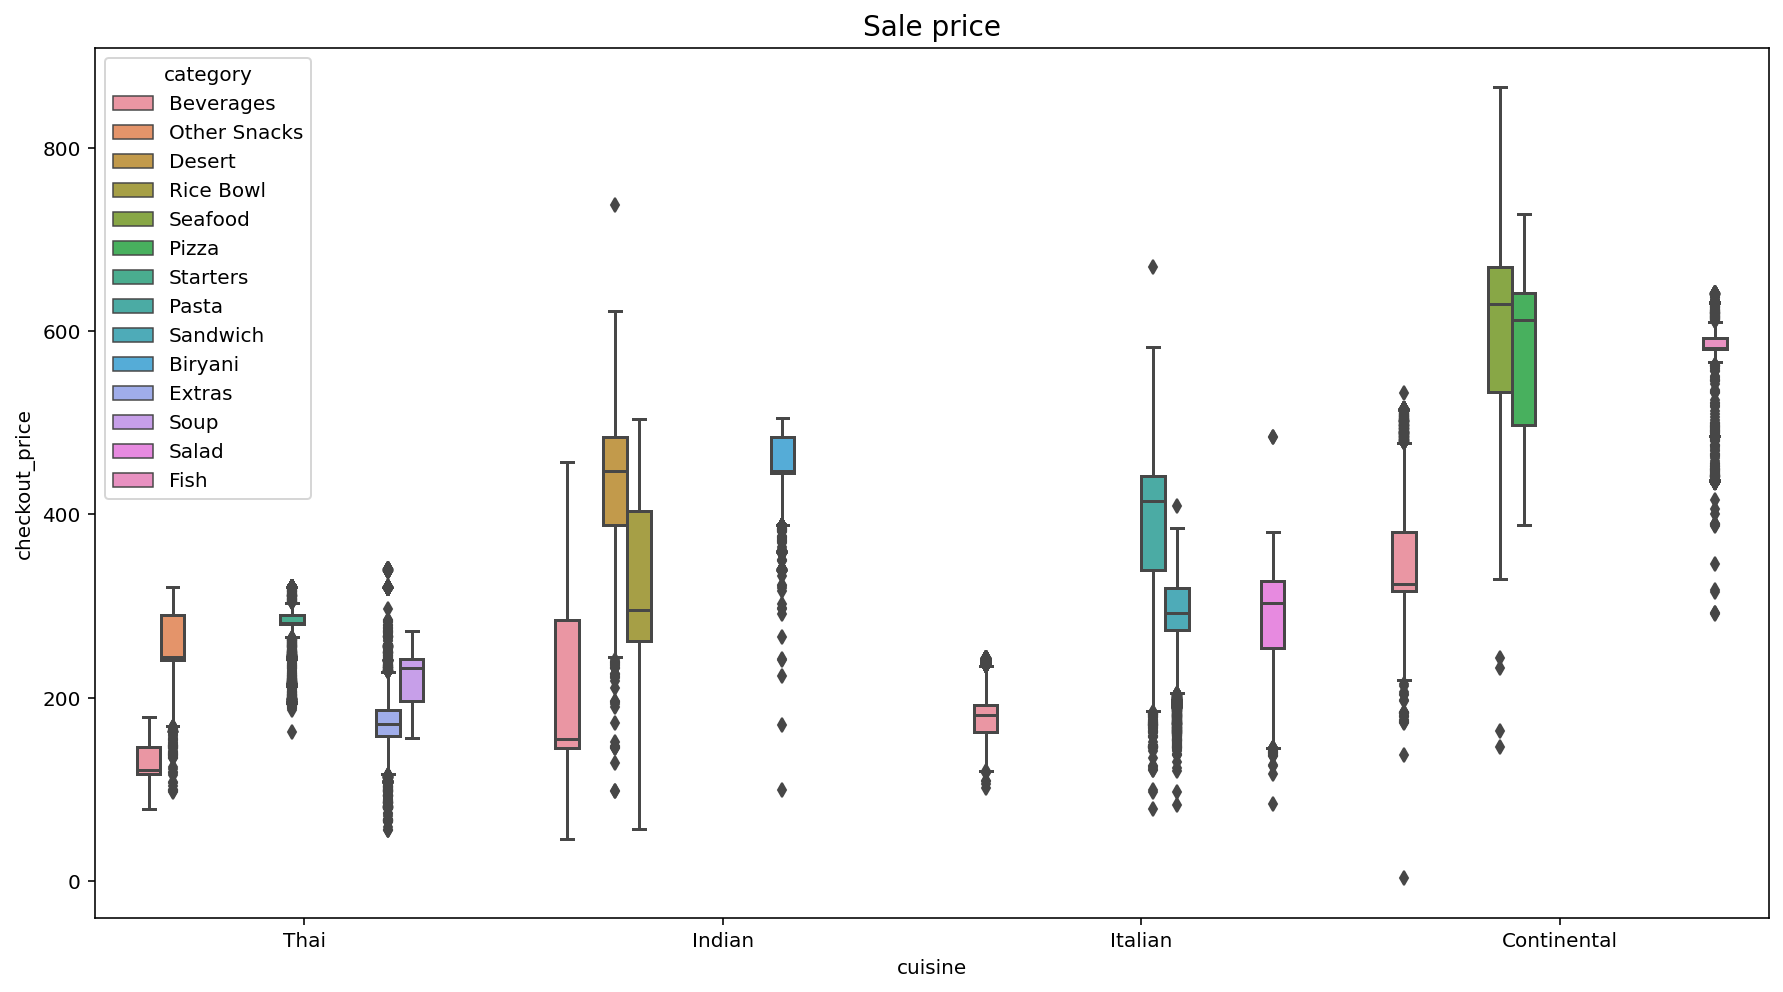

In [ ]:
plt.figure(figsize=(15,8)) # распределение цены в зависимости от категорий
sns.boxplot(y='checkout_price', x='cuisine', hue='category', data=ds);
plt.title('Sale price', fontsize=14);

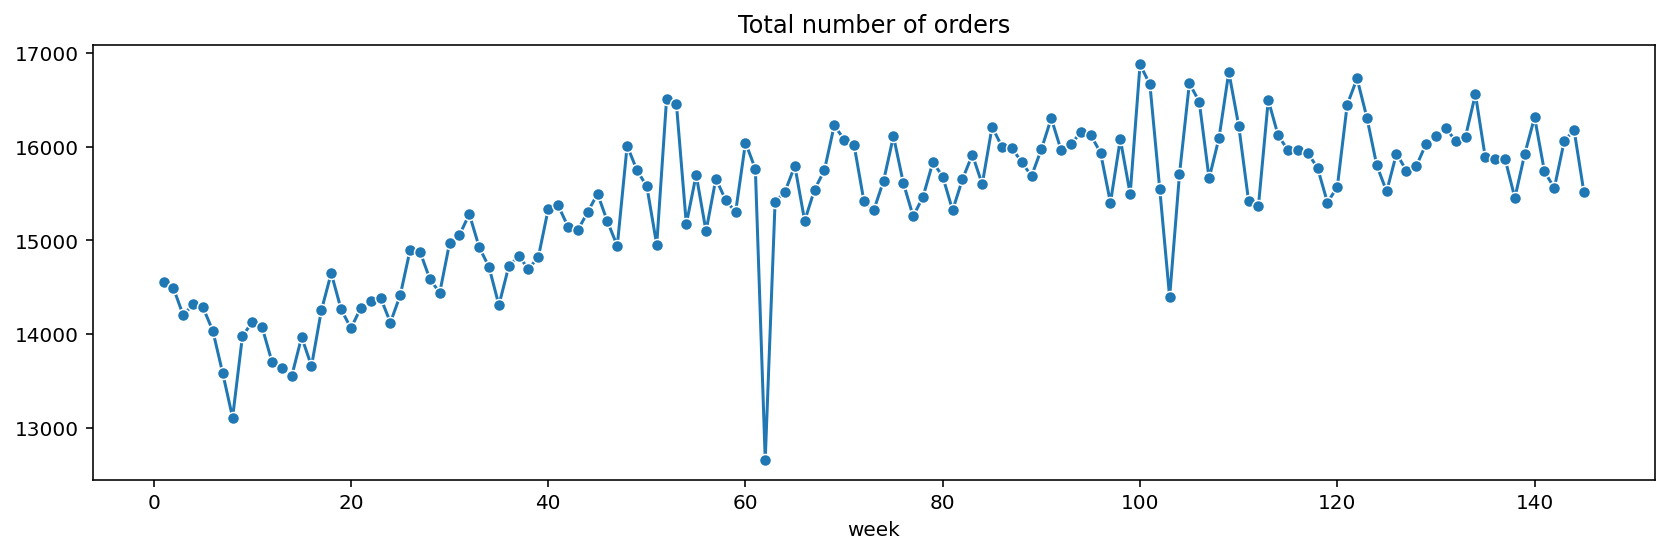

In [ ]:
# Посмотрим как менялось общее число заказов по неделям, а также на распределение кол-ва заказов
sum_orders = ds.groupby(by='week')['num_orders'].sum()
plt.figure(figsize=(14,4))
sns.lineplot(x = sum_orders.index, y = sum_orders.values, marker='o')
plt.title('Total number of orders');

На графике не видим ни очевидного тренда, ни сезонности.

In [ ]:
ds_dummies = pd.get_dummies(ds) # кодируем категориальные фичи

In [ ]:
ds['week'].max()

145

In [ ]:
# разделяем на тренировочную и тестовую выборки - учимся на первых 130 неделях, и предсказываем следующие 15
split_idx = np.where(ds['week']==130)[0][0]
X = ds_dummies.copy()
y = X.pop('num_orders')

(x_train, x_test, y_train, y_test) = (X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]) 

<AxesSubplot:xlabel='checkout_price', ylabel='Count'>

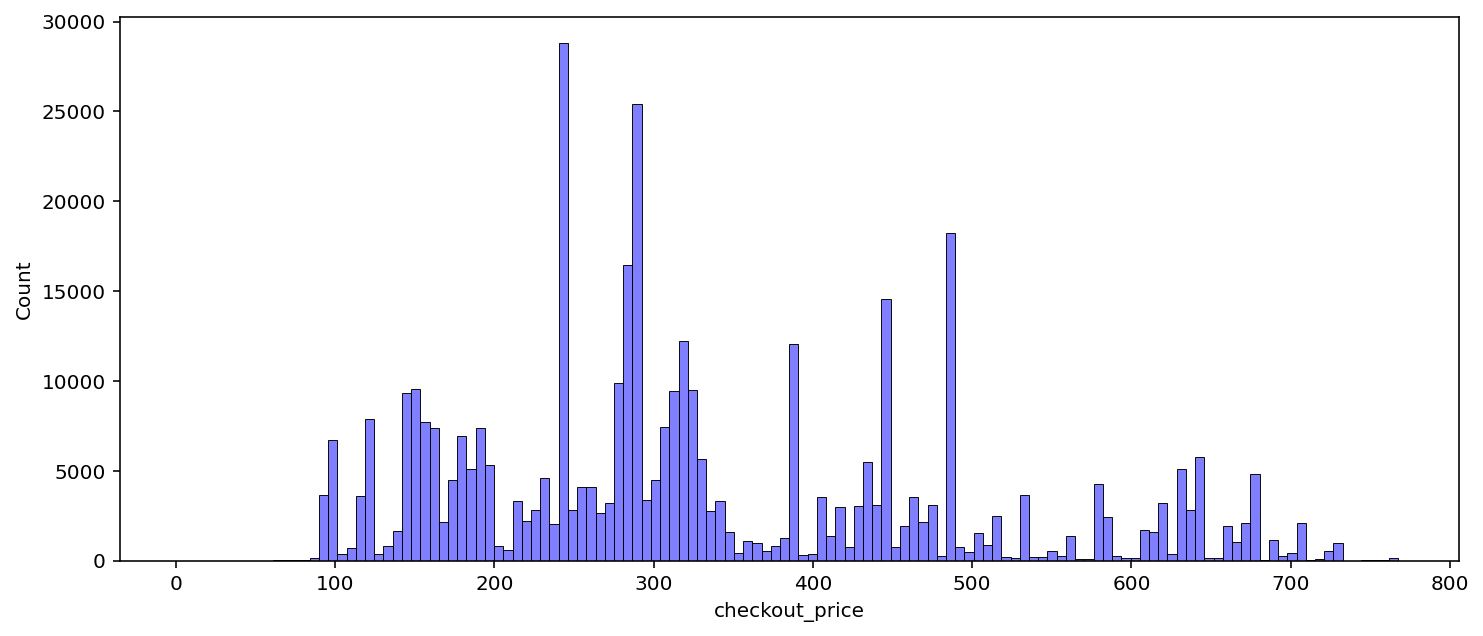

In [ ]:
plt.figure(figsize=(12,5))
sns.histplot(x_train['checkout_price'], label='checkout_price', color='blue', alpha=0.5)
# состоит из нескольких распределений, что объяснимо, т.к. имеем дело с различными группами товаров

In [ ]:

x_train_scl = x_train.copy()
x_test_scl = x_test.copy()

scl = StandardScaler()
x_train_scl[num_cols] = scl.fit_transform(x_train[num_cols]) # масштабируем выборку
x_test_scl[num_cols] = scl.transform(x_test[num_cols]) # масштабируем выборку

# Построение модели

In [ ]:
input_ = keras.layers.Input(shape=(x_train_scl.shape[1],)) # входной слой
x = keras.layers.Dense(500, activation='relu')(input_) # полносвязный слой
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(200, activation='relu')(x) # полносвязный слой
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(100, activation='relu')(x) # полносвязный слой
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(50, activation='relu')(x) # полносвязный слой
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(20, activation='relu')(x) # полносвязный слой
output_ = keras.layers.Dense(1)(x) # выходной слой

model = keras.models.Model(input_, output_) # определем въод и выход моедли

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=6) # ранняя остановка
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                              factor=0.25, 
                                              patience=3, 
                                              verbose=1) # редактирование скорости обучения

model.compile(loss = 'mse', # определяем метрики и алгоритм оптимизации
              optimizer = 'adam',
              metrics = ['mae']
             )

In [ ]:
history = model.fit(x_train_scl, 
                    y_train, 
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks = [early_stop, reduce_lr],
                    shuffle=False
                   ) # сохраняем историю тренировки

Epoch 1/30
2525/2525 [==============================] - 7s 3ms/step - loss: 1.4193 - mae: 0.8527 - val_loss: 0.8756 - val_mae: 0.7745
Epoch 2/30
2525/2525 [==============================] - 6s 2ms/step - loss: 0.4962 - mae: 0.5520 - val_loss: 0.4701 - val_mae: 0.5548
Epoch 3/30
2525/2525 [==============================] - 6s 2ms/step - loss: 0.3966 - mae: 0.4982 - val_loss: 0.4421 - val_mae: 0.5337
Epoch 4/30
2525/2525 [==============================] - 6s 2ms/step - loss: 0.3748 - mae: 0.4832 - val_loss: 0.4141 - val_mae: 0.5065
Epoch 5/30
2525/2525 [==============================] - 6s 2ms/step - loss: 0.3659 - mae: 0.4770 - val_loss: 0.4284 - val_mae: 0.5143
Epoch 6/30
2525/2525 [==============================] - 6s 2ms/step - loss: 0.3598 - mae: 0.4726 - val_loss: 0.4322 - val_mae: 0.5209
Epoch 7/30
2525/2525 [==============================] - 6s 2ms/step - loss: 0.3547 - mae: 0.4690 - val_loss: 0.4107 - val_mae: 0.5036
Epoch 8/30
2525/2525 [==============================] - 6s 2ms

<AxesSubplot:>

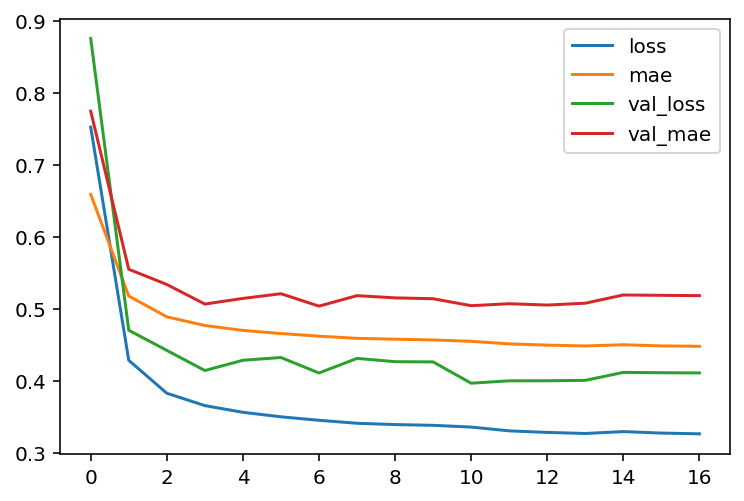

In [ ]:
pd.DataFrame(history.history).iloc[:, :4].plot()

In [ ]:
print('MAE на тестовой выборке: %.3f' %mean_absolute_error(y_test, model.predict(x_test_scl)))

MAE на тестовой выборке: 0.502
